In [7]:
# system
import os
import pickle

# Data objects
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, hstack
from collections import Counter

# Text Manipulation
import re
import string

# Timing
import time

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer

# Models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn import metrics #f1_score, classification_report, confusion_matrix, roc_auc_score

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#load training data
twitter_train = pd.read_excel('./StanceDataset/train.xlsx')

#load test data
twitter_test = pd.read_excel('./StanceDataset/test.xlsx')

In [4]:
twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos


In [5]:
twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [8]:
def preprocess_tweets(x):
    
    # Remove punctuation EXCEPT for hashtags (#) and handles (@)
    exclude_punc = [punc for punc in string.punctuation if punc not in ['#', '@']]
    x_nopunc = ''.join(ch for ch in x if ch not in exclude_punc)

    # lower case
    x_lower = x_nopunc.lower()
    
    # Replace digits with DIGIT
    x_digits = re.sub("\d+", "DIGIT", x_lower)
    
    return x_digits

# Example tweet
print("Raw: " + str(twitter_train['Tweet'][0]))
print("Clean: " + str(preprocess_tweets(twitter_train['Tweet'][0])))

Raw: @tedcruz And, #HandOverTheServer she wiped clean + 30k deleted emails, explains dereliction of duty/lies re #Benghazi,etc #tcot
Clean: @tedcruz and #handovertheserver she wiped clean  DIGITk deleted emails explains dereliction of dutylies re #benghazietc #tcot


In [9]:
# Labels
twitter_train['stance_label'] = np.array(twitter_train['Stance'].apply(lambda x: 
                                                                       2 if x == "FAVOR" else 
                                                                       (1 if x == "NONE" else 0)))
# Clean tweests
twitter_train['tweet_clean'] = np.array(twitter_train['Tweet'].apply(lambda x: preprocess_tweets(x)))

twitter_train.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,stance_label,tweet_clean
0,"@tedcruz And, #HandOverTheServer she wiped cle...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0,@tedcruz and #handovertheserver she wiped clea...
1,Hillary is our best choice if we truly want to...,Hillary Clinton,FAVOR,1. The tweet explicitly expresses opinion abo...,pos,2,hillary is our best choice if we truly want to...
2,@TheView I think our country is ready for a fe...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0,@theview i think our country is ready for a fe...
3,I just gave an unhealthy amount of my hard-ear...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0,i just gave an unhealthy amount of my hardearn...
4,@PortiaABoulger Thank you for adding me to you...,Hillary Clinton,NONE,3. The tweet is not explicitly expressing opi...,pos,1,@portiaaboulger thank you for adding me to you...


In [10]:
# Labels
twitter_test['stance_label'] = np.array(twitter_test['Stance'].apply(lambda x: 
                                                                     2 if x == "FAVOR" else 
                                                                     (1 if x == "NONE" else 0)))
# Clean tweests
twitter_test['tweet_clean'] = np.array(twitter_test['Tweet'].apply(lambda x: preprocess_tweets(x)))

twitter_test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment,stance_label,tweet_clean
0,He who exalts himself shall be humbled; a...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos,0,he who exalts himself shall be humbled an...
1,RT @prayerbullets: I remove Nehushtan -previou...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,other,0,rt @prayerbullets i remove nehushtan previous ...
2,@Brainman365 @heidtjj @BenjaminLives I have so...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,pos,0,@brainmanDIGIT @heidtjj @benjaminlives i have ...
3,#God is utterly powerless without Human interv...,Atheism,AGAINST,1. The tweet explicitly expresses opinion abo...,neg,0,#god is utterly powerless without human interv...
4,@David_Cameron Miracles of #Multiculturalism...,Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,neg,0,@davidcameron miracles of #multiculturalism ...


## Train Elmo models and write outputs to pickle files for use later

# DO NOT RUN UNLESS NECESSARY - TAKES VERY LONG

In [12]:
import tensorflow as tf
import tensorflow_hub as hub

# download elmo model
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)

#function for training elmo model by passing a series of tweets
def elmo_vectors(x):
    embeddings = elmo(x.tolist(), signature="default", as_dict=True)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        # return elmo output
        return sess.run(embeddings)

start_time_train = time.time()
train_elmo = elmo_vectors(twitter_train['tweet_clean'])
print("Training vectors done") 
end_time_train = time.time()
print("Training vectors time:", end_time_train - start_time_train)

start_time_test = time.time()
test_elmo = elmo_vectors(twitter_test['tweet_clean'])
print("Test vectors done")
end_time_test = time.time()
print("Testing vectors time:", end_time_test - start_time_test)

RuntimeError: variable_scope module_1/ was unused but the corresponding name_scope was already taken.

In [29]:
#write training to pickle
pickle1 = open('elmo_train.pickle','wb')
pickle.dump(train_elmo, pickle1)
pickle1.close()

#write test to pickle
pickle2 = open('elmo_test.pickle','wb')
pickle.dump(test_elmo, pickle2)
pickle2.close()

## Code for loading Elmo vectors from pickle files and prepping labelled data

In [19]:
with open("elmo_train.pickle", "rb") as f:
    train_vectors = pickle.load(f)
    
with open("elmo_test.pickle", "rb") as f:
    test_vectors = pickle.load(f)

In [20]:
stance_labels_train = np.array(twitter_train['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

stance_labels_test = np.array(twitter_test['Stance'].apply(lambda x: 
                                                                    2 if x == "FAVOR" else 
                                                                    (1 if x == "NONE" else 0)))

## Helper function for model performances

In [21]:
def confusion_plot(confusion_matrix, target_names):
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Function for implementing SVM with different elmo vectors

In [24]:
def elmo_svm(train, test, topic_list, layer, pooling = None):
    """Function that takes in the elmo vectors, a topic list, the elmo layer to use, and pooling method (if warranted).
    Outputs performance of SVM model based on the defined elmo parameters across defined the user defined topics."""
    
    #convert topic list to lower case
    for i in range(0,len(topic_list)):
        topic_list[i] = topic_list[i].lower()
    
    #find boolean series of all rows pertaining to the relevant topics
    matches_train = twitter_train['Target'].apply(lambda x: x.lower() in topic_list)
    matches_test = twitter_test['Target'].apply(lambda x: x.lower() in topic_list)
    
    #subset labels
    train_labels = stance_labels_train[matches_train]
    test_labels = stance_labels_test[matches_test]
    
    #if default elmo layer, use below logic to find training data (just matches the rows in the topic)
    if layer.lower() == 'default':
        train_data = train['default'][matches_train]
        test_data = test['default'][matches_test]
        
    #train model
    svm = SVC(kernel = 'linear')
    start_time_train = time.time()
    svm.fit(train_data, train_labels)
    end_time_train = time.time()
    print("Training time:", end_time_train - start_time_train)
    
    #prediction
    start_time_predict = time.time()
    stance_predict = svm.predict(test_data)
    end_time_predict = time.time()
    print("Prediction time:", end_time_predict - start_time_predict)
    
    #output metrics
    f1 = f1_score(test_labels, stance_predict, average = 'macro')
    
    report = classification_report(y_true = test_labels, 
                                        y_pred = stance_predict,
                                        target_names = ['Against', 'None', 'Favor'])
    
    confuse = confusion_matrix(y_true = test_labels, y_pred = stance_predict) 
    
    return f1, report, confuse

## Run SVM Models using the 'default' elmo output

Training time: 0.37947583198547363
Prediction time: 0.09637999534606934
F1 score for atheism: 0.48658725677359227
              precision    recall  f1-score   support

     Against       0.82      0.69      0.75       160
        None       0.29      0.43      0.35        28
       Favor       0.31      0.44      0.36        32

   micro avg       0.62      0.62      0.62       220
   macro avg       0.47      0.52      0.49       220
weighted avg       0.68      0.62      0.64       220



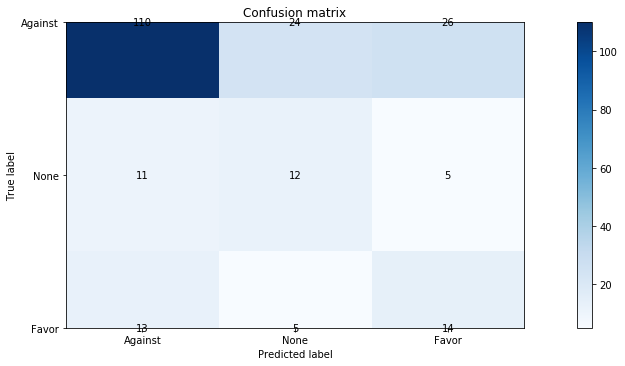

In [29]:
#Atheism
f1_ath, report_ath, confuse_ath = elmo_svm(train_vectors, test_vectors, ['Atheism'], 'default')
print("F1 score for atheism:", f1_ath)
print(report_ath)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_ath, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.6847209930419922
Prediction time: 0.18907809257507324
F1 score for Hillary 0.5313583144854005
              precision    recall  f1-score   support

     Against       0.68      0.81      0.74       172
        None       0.62      0.44      0.51        78
       Favor       0.38      0.31      0.34        45

   micro avg       0.63      0.63      0.63       295
   macro avg       0.56      0.52      0.53       295
weighted avg       0.62      0.63      0.62       295



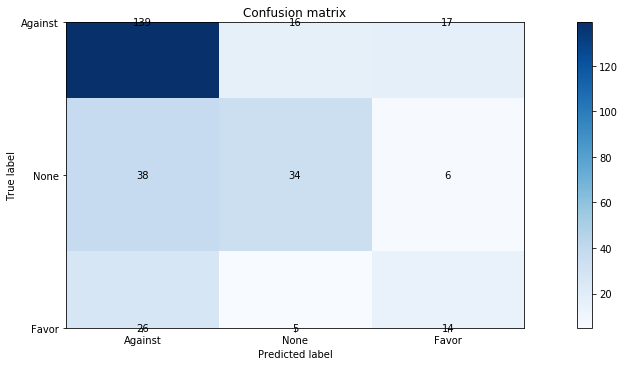

In [31]:
#Hillary
f1_hil, report_hil, confuse_hil = elmo_svm(train_vectors, test_vectors, ['Hillary Clinton'], 'default')
print("F1 score for Hillary", f1_hil)
print(report_hil)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_hil, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.63739013671875
Prediction time: 0.16240882873535156
F1 score for Abortion 0.5646797908551777
              precision    recall  f1-score   support

     Against       0.81      0.69      0.75       189
        None       0.34      0.56      0.42        45
       Favor       0.52      0.52      0.52        46

   micro avg       0.64      0.64      0.64       280
   macro avg       0.56      0.59      0.56       280
weighted avg       0.69      0.64      0.66       280



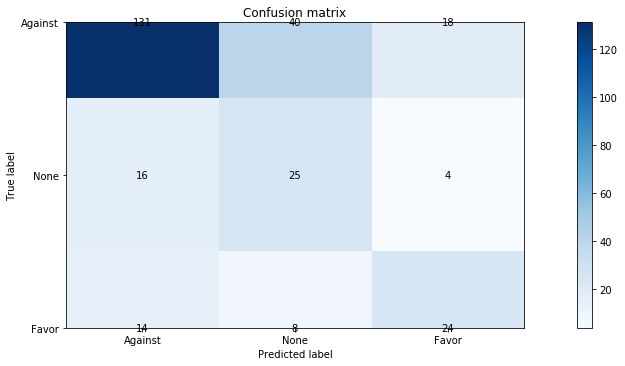

In [32]:
#Abortion
f1_abort, report_abort, confuse_abort = elmo_svm(train_vectors, test_vectors, ['Legalization of Abortion'], 'default')
print("F1 score for Abortion", f1_abort)
print(report_abort)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_abort, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.24268198013305664
Prediction time: 0.06546306610107422
F1 score for climate change 0.5247559458085774
              precision    recall  f1-score   support

     Against       0.33      0.09      0.14        11
        None       0.55      0.66      0.60        35
       Favor       0.83      0.84      0.83       123

   micro avg       0.75      0.75      0.75       169
   macro avg       0.57      0.53      0.52       169
weighted avg       0.74      0.75      0.74       169



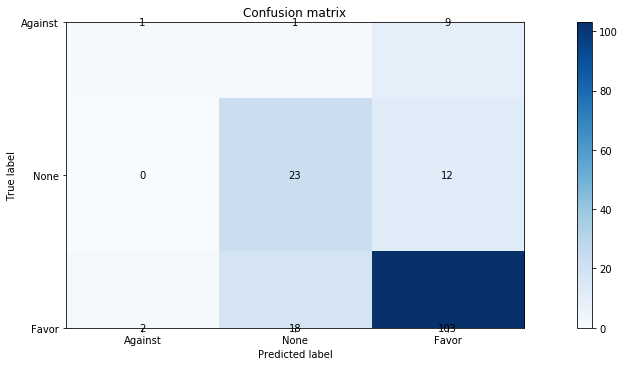

In [33]:
#Climate
f1_clim, report_clim, confuse_clim = elmo_svm(train_vectors, test_vectors, ['Climate Change is a Real Concern'], 'default')
print("F1 score for climate change", f1_clim)
print(report_clim)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_clim, ['Against', 'None', 'Favor'])
plt.show()

Training time: 0.7173500061035156
Prediction time: 0.1788170337677002
F1 score for feminist mov 0.47482865002201496
              precision    recall  f1-score   support

     Against       0.72      0.63      0.67       183
        None       0.41      0.34      0.37        44
       Favor       0.32      0.48      0.38        58

   micro avg       0.55      0.55      0.55       285
   macro avg       0.48      0.48      0.47       285
weighted avg       0.59      0.55      0.57       285



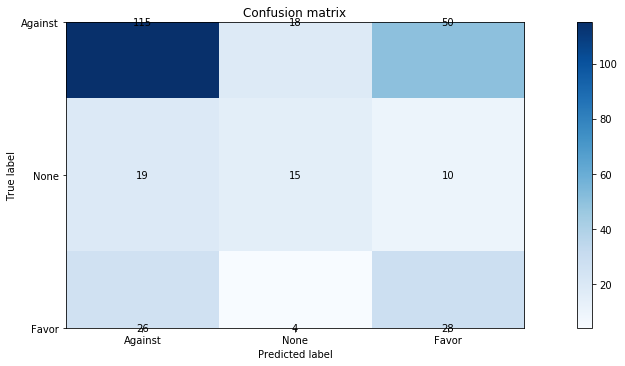

In [35]:
#Feminism
f1_fem, report_fem, confuse_fem = elmo_svm(train_vectors, test_vectors, ['Feminist Movement'], 'default')
print("F1 score for feminist mov", f1_fem)
print(report_fem)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_fem, ['Against', 'None', 'Favor'])
plt.show()

Training time: 9.884015321731567
Prediction time: 2.907104730606079
F1 score for all topics 0.5225258461049768
              precision    recall  f1-score   support

     Against       0.69      0.67      0.68       715
        None       0.41      0.47      0.44       230
       Favor       0.46      0.45      0.45       304

   micro avg       0.58      0.58      0.58      1249
   macro avg       0.52      0.53      0.52      1249
weighted avg       0.58      0.58      0.58      1249



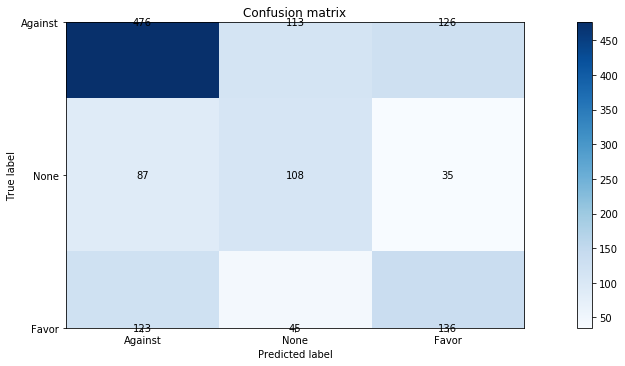

In [36]:
#All
all_tops = ['Hillary Clinton', 'Legalization of Abortion', 'Climate Change is a Real Concern',
           'Feminist Movement', 'Atheism']
f1_all, all_report, confuse_all = elmo_svm(train_vectors, test_vectors, all_tops, 'default')
print("F1 score for all topics", f1_all)
print(all_report)

plt.figure(figsize=(15, 5))
confusion_plot(confuse_all, ['Against', 'None', 'Favor'])
plt.show()